In [7]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
import sklearn.decomposition

plt.rcParams['text.usetex'] = True
# plt.style.use('ggplot')
colors = ["#0072BD","#D95319","#EDB120","#7E2F8E","#77AC30","#4DBEEE","#A2142F"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

## Set up PCA and generate random data

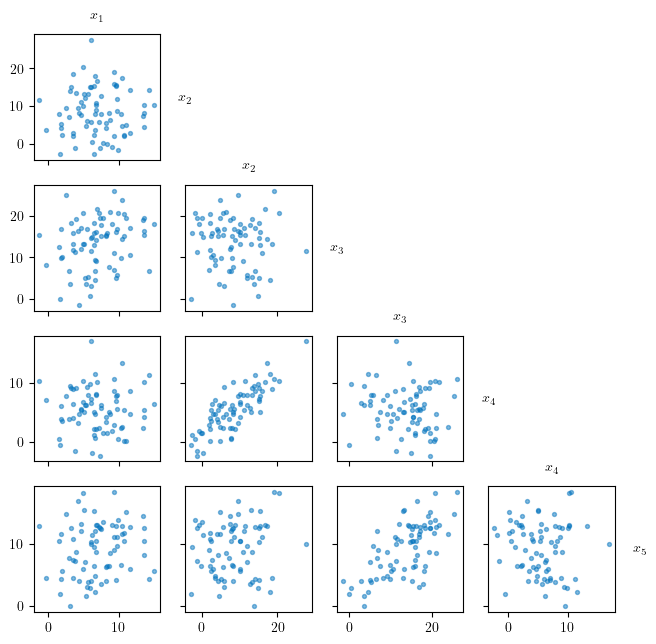

In [8]:
# Set the dimension of the data m x n
n = 5 # >= 2
m = 75 # >= n

# Set the rank p for the PCA projection
# p = n # full rank
p = n-1 # remove component with smallest variance
# p = int(n/2) # remove half of the components

# Generate random data with increasing variances
rng = np.random.default_rng(12+12+12+123) # set random generator seed for reproducability
mean = np.linspace(1, 5, n)
cov = np.diag(np.linspace(1,10, n))
X = rng.multivariate_normal(mean, cov, m)
X += 2*np.roll(X, -2, 1) # add relationships

# plot data
pair_props = dict(alpha=pow(2/m, 1/5), s=8)
if n > 2:
    # generate pairplots
    fig, ax = plt.subplots(n-1, n-1, figsize=(n*1.5, n*1.5), sharex='col', sharey='row')
    for i in range(n-1):
        ax[i,i].set_xlabel(f"$x_{i+1}$")
        ax[i,i].xaxis.set_label_coords(.5,1.2)
        ax[i,i].set_ylabel(f"$x_{i+2}$", rotation=0)
        ax[i,i].yaxis.set_label_coords(1.2,.5-.05)
        # last row
        ax[n-2,i].scatter(X[:,i], X[:,n-1], **pair_props)
        for j in range(i):
            # upper triangle
            ax[j,i].set_axis_off()
            # lower triangle
            ax[i-1,j].scatter(X[:,j], X[:,i], **pair_props)
else:
    # xy scatter plot for n = 2
    plt.figure(figsize=(3,3))
    plt.scatter(*X.T, **pair_props)
plt.show()


## Simple PCA algorithm

1. Compute the covariance matrix (centered data)
2. Find eigenvalues and eigenvectors
3. Project along the first `p` components

In [9]:
# create PCA helper functions
def adjust_column_signs(A):
    """
    Multiplies each column in `A` by the sign of its largest component.
    This ensures that the largest component is positive.
    """
    a = np.asarray(A)           # ensure numpy array
    idx = np.abs(a).argmax(0)   # find largest magnitude in each column
    jdx = range(a.shape[1])     # get all column indices
    maxvals = a[idx, jdx]       # get signed maximum values in each column
    return a * np.sign(maxvals) # return array with changed signs

def eig_sort(D,V):
    """
    Parameters
    ----------
    `D` : 1D array or list of eigenvalues
    `V` : 2D array of eigenvectors

    Outputs
    ------
    `d` : sorted eigenvalues
    `v` : sorted eigenvectors
    """
    d = np.asarray(D)       # ensure numpy arrays
    v = np.asarray(V)       # 
    idx = np.argsort(d)     # get ordered indices
    idx = idx[::-1]         # get decreasing order
    return d[idx], v[:,idx] # return sorted eigenvalues, eigenvectors

def simple_PCA(X, n_components=None):
    """
    Parameters
    ----------
    `X` : m by n data matrix. Columns are variables and rows are observations.
    `n_components` : Number of principal components to keep. Corresponds to the rank of the projection.

    Output
    ------
    `coeff` : Principal component coefficients. Each column of the `coeff` array corresponds to a principal component vector. Components are ordered by decreasing variances.
    `score` : Projection of data onto PCA components.
    `latent` : Explained variances.
    """
    X0 = X - X.mean(0)
    # compute covariance matrix
    C = X0.T @ X0
    # eigenvalue decomposition
    D, V = np.linalg.eigh(C)
    V = adjust_column_signs(V)
    D, V = eig_sort(D, V)
    # set projection to full rank if n_components is not specified
    if n_components == None:
        n_components = np.shape(X)[1]
    # throw away components with the least variance
    latent = D[:n_components]
    coeff = V[:,:n_components]
    # compute PCA projections
    score = (X - np.mean(X,0)) @ coeff
    return coeff, score, latent

Run the Simple PCA algorithm and check reconstruction error.

In [10]:
# Do simple pca
V, PX, D = simple_PCA(X, n_components=p)
# Reconstruct X using rank p projection and column means
Xhat = PX @ V.T + X.mean(0)
# Compute reconstruction error
simple_error = np.linalg.norm(X - Xhat)
print(f"Simple PCA reconstruction error = {simple_error}")

Simple PCA reconstruction error = 14.453752135688845


## Use Scikit Learn PCA

In [11]:
# Fit PCA with Scikit Learn
pca = sklearn.decomposition.PCA(n_components=p)
fit = pca.fit(X)
# Get projections
TX = fit.transform(X)
# Reconstruction X
Xhat2 = fit.inverse_transform(TX)
# Compute reconstruction error
skl_error = np.linalg.norm(X - Xhat2)
print(f"Scikit Learn PCA reconstruction error = {skl_error}")

Scikit Learn PCA reconstruction error = 14.453752135688845


## Compare

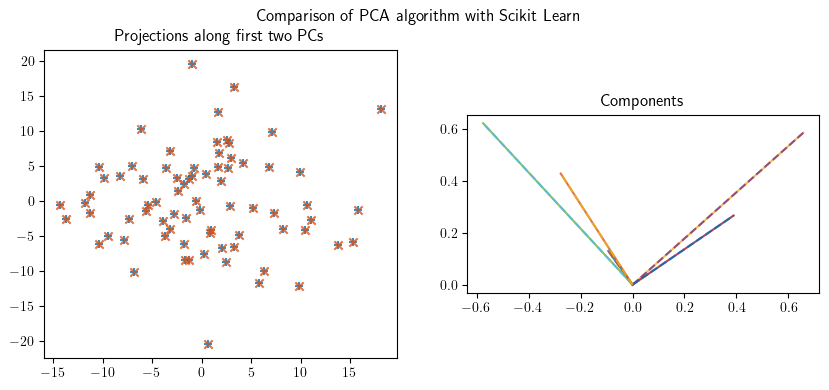

In [12]:
# Correct directions for Scikit components and get projections
W = adjust_column_signs(fit.components_.T)
TX = (X - fit.mean_) @ W

# create subplots
fig, ax = plt.subplots(1,2, figsize=(10,4))
fig.suptitle("Comparison of PCA algorithm with Scikit Learn")

# plot original projections
alph = .8
ax[0].set_title("Projections along first two PCs")
ax[0].scatter(*TX.T[:2], marker='+', alpha=alph)
ax[0].scatter(*PX.T[:2], marker='x', alpha=alph)

# plot components
ax[1].set_title("Components")
ax[1].set_aspect('equal')
for i in range(n):
    ax[1].plot([0,W[i,0]], [0,W[i,1]], alpha=alph)
    ax[1].plot([0,V[i,0]], [0,V[i,1]], linestyle='--', alpha=alph)

plt.show()